<a href="https://colab.research.google.com/github/abagnard/266FinalProject/blob/main/W266_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [104]:
import os, sys, re, csv, json, time, unittest
import itertools, collections
from importlib import reload

import pandas as pd
import numpy as np
from scipy import stats

# Data Scraper Packages
from   bs4    import BeautifulSoup
from   urllib.request import urlopen

# Clean Data Packages
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import glob

import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# FOMC Data Loader

In [145]:
# Pull Dates of FOMC meetings
df_date = pd.read_csv("data/FOMC_data/FOMC_meeting_dates.csv")
meeting_dates = df_date["MeetingDate"].values.tolist()

## Create DataFrame with Clean Data
- Includes press_conference flag that denotes whether a press conference was held for that FOMC meeting

In [146]:
clean_file_names = glob.glob('data/FOMC_data/FOMC_data_clean/*.txt')

FOMC_records = []
for clean_file_name in clean_file_names:
    meeting_date = clean_file_name.split('/')[-1].split('_')[-1][:-4]
    press_conference = df_date[df_date['MeetingDate'] == int(meeting_date)].iloc[0]['PressConference']
    data = open(clean_file_name).read()
    
    if 'Minutes' in clean_file_name:
        file_type = 'minutes'
        release_date = df_date[df_date['MeetingDate'] == int(meeting_date)].iloc[0]['MinuteNotesReleaseDate']
        # Pull data without stopwords
        file_name = clean_file_name[-24:]
        data_without_stopwords = open('data/FOMC_data/FOMC_data_clean/FOMC_data_clean_without_stopwords/' + file_name).read()
    
    else:
        file_type = 'statement'
        release_date = meeting_date
        # Pull data without stopwords        
        file_name = clean_file_name[-26:]
        data_without_stopwords = open('data/FOMC_data/FOMC_data_clean/FOMC_data_clean_without_stopwords/' + file_name).read()
    
    FOMC_record = {'FOMC_date': meeting_date, 'release_date': release_date, 'document_type': file_type, 'press_conference': press_conference, 'document_data': data, 'document_data_wo_stopwords': data_without_stopwords}
    FOMC_records.append(FOMC_record)


df_FOMC_raw = pd.DataFrame(FOMC_records)

In [147]:
df_FOMC_raw.FOMC_date = pd.to_datetime(df_FOMC_raw.FOMC_date, format='%Y%m%d')
df_FOMC_raw.release_date = pd.to_datetime(df_FOMC_raw.release_date, format='%Y%m%d')

df_FOMC_raw.head()

,FOMC_date,document_data,document_data_wo_stopwords,document_type,press_conference,release_date
0,2006-01-31,minutes of the FOMC january 31 2006 a meeting ...,minutes FOMC january 31 2006 meeting FOMC held...,minutes,0,2006-02-21
1,2000-10-03,for immediate release the FOMC at its meeting ...,immediate release FOMC meeting today decided m...,statement,0,2000-10-03
2,2000-03-21,for immediate release the FOMC voted today to ...,immediate release FOMC voted today raise targe...,statement,0,2000-03-21
3,2011-01-26,information received since the FOMC met in dec...,information received since FOMC met december c...,statement,0,2011-01-26
4,2002-11-06,for immediate release the FOMC decided today t...,immediate release FOMC decided today lower tar...,statement,0,2002-11-06


In [148]:
df_FOMC_512_raw = df_FOMC_raw

def pull_middle_512_words(data):
    data = data.split(' ')
    midpoint = len(data)//2
    start_idx = midpoint - 250
    end_idx = midpoint + 250
    data_512 = ''
    
    if start_idx < 0:
        if end_idx > len(data):
            data_512 = ' '.join(data)
        else:
            data_512 = ' '.join(data[0: end_idx])
    else:
        if end_idx > len(data):
            data_512 = ' '.join(data[start_idx: ])
        else: 
            data_512 = ' '.join(data[start_idx: end_idx])
    return data_512
    

df_FOMC_512_raw['document_data_512'] = df_FOMC_512_raw['document_data'].apply(lambda data: pull_middle_512_words(data))
df_FOMC_512_raw['document_data_wo_stopwords_512'] = df_FOMC_512_raw['document_data_wo_stopwords'].apply(lambda data: pull_middle_512_words(data))


In [132]:
five12_perc_of_doc_length = df_FOMC_512_raw[['document_type','document_data', 'document_data_wo_stopwords', 'document_data_512','document_data_wo_stopwords_512']]

def count_words(data):
    data = data.split(' ')
    return len(data)

five12_perc_of_doc_length['document_data_len'] = five12_perc_of_doc_length['document_data'].apply(lambda data: count_words(data))
five12_perc_of_doc_length['document_data_wo_stopwords_len'] = five12_perc_of_doc_length['document_data_wo_stopwords'].apply(lambda data: count_words(data))
five12_perc_of_doc_length['document_data_512_len'] = five12_perc_of_doc_length['document_data_512'].apply(lambda data: count_words(data))
five12_perc_of_doc_length['document_data_wo_stopwords_512_len'] = five12_perc_of_doc_length['document_data_wo_stopwords_512'].apply(lambda data: count_words(data))


/Users/Lex/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/Lex/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [135]:
five12_perc_of_doc_length
smaller_df = five12_perc_of_doc_length[['document_type', 'document_data_wo_stopwords_len','document_data_wo_stopwords_512_len']]
smaller_df.head()

,document_type,document_data_wo_stopwords_len,document_data_wo_stopwords_512_len
0,minutes,498,498
1,statement,117,117
2,statement,137,137
3,statement,240,240
4,statement,111,111


In [143]:
smaller_df.groupby('document_type')[['document_data_wo_stopwords_len', 'document_data_wo_stopwords_512_len']].mean()

,document_data_wo_stopwords_len,document_data_wo_stopwords_512_len
document_type,,
minutes,4093.903670,497.311927
statement,200.478261,200.402174


In [144]:
smaller_df.groupby('document_type')[['document_data_wo_stopwords_len', 'document_data_wo_stopwords_512_len']].max()

,document_data_wo_stopwords_len,document_data_wo_stopwords_512_len
document_type,,
minutes,8846,500
statement,512,500


### Rename Column Names for 512 subselection

In [41]:
# df_FOMC_512_raw = df_FOMC_512_raw.drop(['document_data', 'document_data_wo_stopwords'], axis = 1)
# df_FOMC_512_raw = df_FOMC_512_raw.rename(columns = {'document_data_512': 'document_data', 'document_data_wo_stopwords_512': 'document_data_wo_stopwords'})

In [103]:
# df_FOMC_512_raw['document_type'].value_counts()

minutes      218
statement    184
Name: document_type, dtype: int64

## Add Lables to DataFrame
- Label_Data file includes code on how we caluclate our data lables

#### Create df with labels

In [149]:
# df_market_data_labels = pd.read_csv('data/Market_data/market_data_labels_by_date.csv', parse_dates=['Date'])
df_market_data_labels = pd.read_csv('data/Market_data/label_data_v2.csv', parse_dates=['Date'])
df_market_data_labels.head()


,Unnamed: 0,Date,Press Release,symbol,open,high,low,close,volume,day_before_close,...,prev_fed_rate,pct_change_in_fed_rate,10_yr,one_day_before_10,two_day_before_10,three_day_before_10,prev_days_avg_treas,pct_change_in_treas,label_market,label_FED
0,0,1993-02-03,0,SP500,442.56,447.35,442.56,447.20,345410000,409.53,...,3.08,-15.584416,6.45,7.36,9.01,8.21,8.193333,-27.028424,0,-1
1,1,1993-03-23,0,SP500,448.88,449.80,448.30,448.76,232730000,409.91,...,2.92,-0.342466,5.91,7.62,8.52,9.43,8.523333,-44.218838,0,-1
2,2,1993-05-18,0,SP500,440.39,441.26,437.95,440.32,264300000,412.81,...,2.94,-1.020408,6.15,7.28,8.75,8.78,8.270000,-34.471545,0,-1
3,3,1993-07-07,0,SP500,441.40,443.63,441.40,442.83,253170000,409.16,...,3.09,-9.708738,5.80,6.87,8.02,8.95,7.946667,-37.011494,0,-1
4,4,1993-08-17,0,SP500,452.38,453.70,451.96,453.13,261320000,420.74,...,3.02,-2.649007,5.70,6.56,8.80,8.18,7.846667,-37.660819,0,-1


#### Update FED and market labels to be positive
- BERT models will throw errors if labels are negative

In [150]:
df_market_data_labels['label_market_raw'] = df_market_data_labels['label_market']
df_market_data_labels['label_FED_raw'] = df_market_data_labels['label_FED']

df_market_data_labels['label_market'] = df_market_data_labels['label_market_raw'] + 1
df_market_data_labels['label_FED'] = df_market_data_labels['label_FED_raw'] + 1

print(df_market_data_labels[['label_market', 'label_FED']].describe())

       label_market   label_FED
count    442.000000  442.000000
mean       0.696833    0.952489
std        0.566197    0.796822
min        0.000000    0.000000
25%        0.000000    0.000000
50%        1.000000    1.000000
75%        1.000000    2.000000
max        2.000000    2.000000


In [151]:
df_FOMC_labeled =  pd.merge(df_FOMC_512_raw, df_market_data_labels, left_on='FOMC_date', right_on='Date')
df_FOMC_labeled.head()

,FOMC_date,document_data,document_data_wo_stopwords,document_type,press_conference,release_date,document_data_512,document_data_wo_stopwords_512,Unnamed: 0,Date,...,10_yr,one_day_before_10,two_day_before_10,three_day_before_10,prev_days_avg_treas,pct_change_in_treas,label_market,label_FED,label_market_raw,label_FED_raw
0,2006-01-31,minutes of the FOMC january 31 2006 a meeting ...,minutes FOMC january 31 2006 meeting FOMC held...,minutes,0,2006-02-21,mr reinhart secretary and economist ms danker ...,conduct,104,2006-01-31,...,4.53,4.14,4.00,5.07,4.403333,2.796174,1,1,0,0
1,2006-01-31,for immediate release share the FOMC decided t...,immediate release share FOMC decided today rai...,statement,0,2006-01-31,for immediate release share the FOMC decided t...,immediate release share FOMC decided today rai...,104,2006-01-31,...,4.53,4.14,4.00,5.07,4.403333,2.796174,1,1,0,0
2,2000-10-03,for immediate release the FOMC at its meeting ...,immediate release FOMC meeting today decided m...,statement,0,2000-10-03,percent recent data have indicated that the ex...,immediate release FOMC meeting today decided m...,61,2000-10-03,...,5.87,6.01,6.61,6.13,6.250000,-6.473595,0,2,-1,1
3,2000-10-03,minutes of the FOMC october 3 2000 a meeting o...,minutes FOMC october 3 2000 meeting FOMC held ...,minutes,0,2000-11-16,aggregate demand and aggregate supply were com...,advance twelve months ended august slightly la...,61,2000-10-03,...,5.87,6.01,6.61,6.13,6.250000,-6.473595,0,2,-1,1
4,2000-03-21,for immediate release the FOMC voted today to ...,immediate release FOMC voted today raise targe...,statement,0,2000-03-21,the FOMC met in february the FOMC remains conc...,immediate release FOMC voted today raise targe...,57,2000-03-21,...,6.13,6.74,6.28,7.16,6.726667,-9.733551,0,2,-1,1


In [152]:
df_FOMC_labeled_small = df_FOMC_labeled[['FOMC_date', 'document_type', 'document_data', 'document_data_wo_stopwords', 'document_data_512', 'document_data_wo_stopwords_512', 'press_conference', 'release_date','label_market', 'label_FED']].copy()
df_FOMC = df_FOMC_labeled_small
df_FOMC.head()

# df_FOMC.to_csv("data/FOMC_labeled_data.csv")

,FOMC_date,document_type,document_data,document_data_wo_stopwords,document_data_512,document_data_wo_stopwords_512,press_conference,release_date,label_market,label_FED
0,2006-01-31,minutes,minutes of the FOMC january 31 2006 a meeting ...,minutes FOMC january 31 2006 meeting FOMC held...,mr reinhart secretary and economist ms danker ...,conduct,0,2006-02-21,1,1
1,2006-01-31,statement,for immediate release share the FOMC decided t...,immediate release share FOMC decided today rai...,for immediate release share the FOMC decided t...,immediate release share FOMC decided today rai...,0,2006-01-31,1,1
2,2000-10-03,statement,for immediate release the FOMC at its meeting ...,immediate release FOMC meeting today decided m...,percent recent data have indicated that the ex...,immediate release FOMC meeting today decided m...,0,2000-10-03,0,2
3,2000-10-03,minutes,minutes of the FOMC october 3 2000 a meeting o...,minutes FOMC october 3 2000 meeting FOMC held ...,aggregate demand and aggregate supply were com...,advance twelve months ended august slightly la...,0,2000-11-16,0,2
4,2000-03-21,statement,for immediate release the FOMC voted today to ...,immediate release FOMC voted today raise targe...,the FOMC met in february the FOMC remains conc...,immediate release FOMC voted today raise targe...,0,2000-03-21,0,2


#### Add Label Each Document Based Original Label

In [153]:
def calcSentimentLabel(score):
    label = 'neutral'
    
    if score == 0:
        label = 'negative'
    elif score == 2:
        label = 'positive'
        
    return label

df_FOMC['str_label_market'] = df_FOMC['label_market'].apply(lambda score: calcSentimentLabel(score))
df_FOMC['str_label_FED'] = df_FOMC['label_FED'].apply(lambda score: calcSentimentLabel(score))

In [154]:
df_FOMC.head()

,FOMC_date,document_type,document_data,document_data_wo_stopwords,document_data_512,document_data_wo_stopwords_512,press_conference,release_date,label_market,label_FED,str_label_market,str_label_FED
0,2006-01-31,minutes,minutes of the FOMC january 31 2006 a meeting ...,minutes FOMC january 31 2006 meeting FOMC held...,mr reinhart secretary and economist ms danker ...,conduct,0,2006-02-21,1,1,neutral,neutral
1,2006-01-31,statement,for immediate release share the FOMC decided t...,immediate release share FOMC decided today rai...,for immediate release share the FOMC decided t...,immediate release share FOMC decided today rai...,0,2006-01-31,1,1,neutral,neutral
2,2000-10-03,statement,for immediate release the FOMC at its meeting ...,immediate release FOMC meeting today decided m...,percent recent data have indicated that the ex...,immediate release FOMC meeting today decided m...,0,2000-10-03,0,2,negative,positive
3,2000-10-03,minutes,minutes of the FOMC october 3 2000 a meeting o...,minutes FOMC october 3 2000 meeting FOMC held ...,aggregate demand and aggregate supply were com...,advance twelve months ended august slightly la...,0,2000-11-16,0,2,negative,positive
4,2000-03-21,statement,for immediate release the FOMC voted today to ...,immediate release FOMC voted today raise targe...,the FOMC met in february the FOMC remains conc...,immediate release FOMC voted today raise targe...,0,2000-03-21,0,2,negative,positive


### Bar Plots of Lable Counts

Total FED Label Counts
positive    167
negative    125
neutral     108
Name: str_label_FED, dtype: int64
-----------------------------------------------------


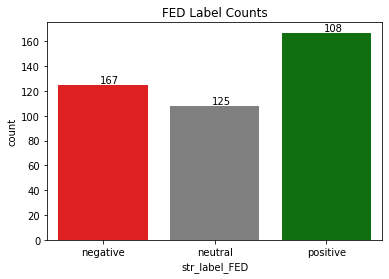

In [155]:
print("Total FED Label Counts")
print(df_FOMC['str_label_FED'].value_counts())
print('-----------------------------------------------------')

ax = sns.countplot(df_FOMC['str_label_FED'], order=['negative', 'neutral', 'positive'], palette=['red','grey','green'])
plt.xlabel('str_label_FED')
plt.title('FED Label Counts')

for p, label in zip(ax.patches, df_FOMC["str_label_FED"].value_counts()):
    ax.annotate(label, (p.get_x()+0.375, p.get_height()+1))


Total Market Label Counts
neutral     255
negative    125
positive     20
Name: str_label_market, dtype: int64
-----------------------------------------------------


Text(0.5, 1.0, 'Market Label Counts')

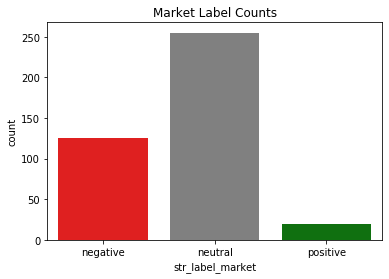

In [156]:
print("Total Market Label Counts")
print(df_FOMC['str_label_market'].value_counts())
print('-----------------------------------------------------')

ax = sns.countplot(df_FOMC['str_label_market'], order=['negative', 'neutral', 'positive'], palette=['red','grey','green'])
plt.xlabel('str_label_market')
plt.title('Market Label Counts')

# ax = sns.countplot(data=df_FOMC, x='document_type', hue = 'str_label_market',palette=['red','grey','green']) #order=['negative', 'neutral', 'positive'], palette=['red','grey','green'])
# plt.xlabel('str_label_market')
# plt.title('Market Label Counts by Document Type')



# Top 20 Most Common Words

In [157]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features = 20)

# ALL Documents
cv.fit(df_FOMC['document_data_wo_stopwords'])
top_20_words_all = cv.get_feature_names()

top_20_words_all = pd.DataFrame(top_20_words_all)
top_20_words_all.columns = ['Top 20 Words']
top_20_words_all['top_word_ranking'] = top_20_words_all.reset_index().index
top_20_words_all

# Statements Only
statements = df_FOMC[df_FOMC['document_type'] == 'statement']
cv.fit(statements['document_data_wo_stopwords'])
top_20_words_statement = cv.get_feature_names()

top_20_words_statement = pd.DataFrame(top_20_words_statement)
top_20_words_statement.columns = ['Statment Top 20 Words']
top_20_words_statement['top_word_ranking'] = top_20_words_statement.reset_index().index
top_20_words_statement

# Minutes Only
minutes = df_FOMC[df_FOMC['document_type'] == 'minutes']
cv.fit(minutes['document_data_wo_stopwords'])
top_20_words_minutes = cv.get_feature_names()

top_20_words_minutes = pd.DataFrame(top_20_words_minutes)
top_20_words_minutes.columns = ['Minutes Top 20 Words']
top_20_words_minutes['top_word_ranking'] = top_20_words_minutes.reset_index().index
top_20_words_minutes

column_names = ['top_word_ranking', 'Top 20 Words', 'Statment Top 20 Words','Minutes Top 20 Words']

# top_20 = pd.DataFrame(results.toarray(). columns=features)
print("Top 20 Words After Removing Stop Words")
top_20_words_all.merge(top_20_words_statement, left_on='top_word_ranking', right_on='top_word_ranking').merge(top_20_words_minutes, left_on='top_word_ranking', right_on='top_word_ranking')[column_names]

Top 20 Words After Removing Stop Words


,top_word_ranking,Top 20 Words,Statment Top 20 Words,Minutes Top 20 Words
0,0,board,committee,board
1,1,committee,conditions,committee
2,2,conditions,economic,economic
3,3,economic,federal,federal
4,4,federal,financial,financial
5,5,financial,funds,growth
6,6,growth,growth,inflation
7,7,inflation,inflation,market
8,8,market,information,meeting
9,9,meeting,labor,members


# FOMC Word Cloud

### FOMC Statements & Minutes Word Cloud

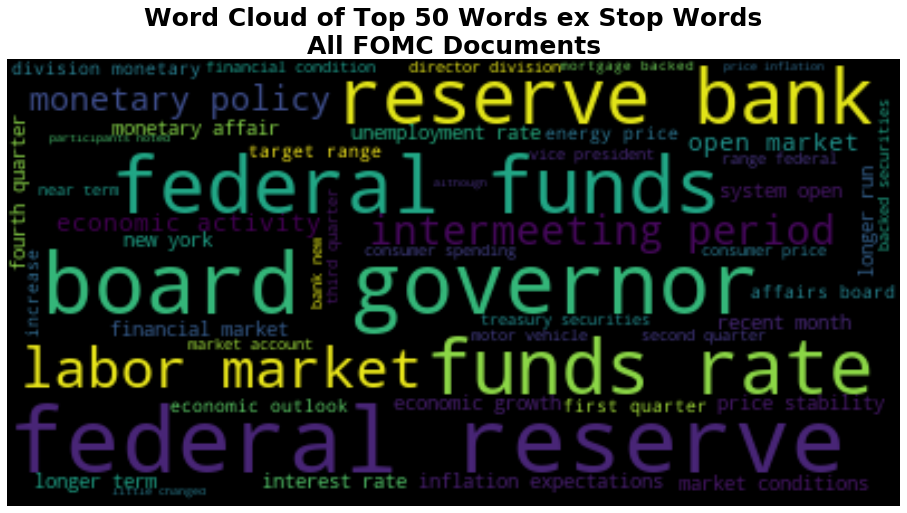

In [158]:
# pip install wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 10))

text = ' '.join(df_FOMC['document_data_wo_stopwords'])
wordcloud = WordCloud(max_words=50).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Top 50 Words ex Stop Words\nAll FOMC Documents", fontweight='bold', fontsize = 25)
plt.show()

# Save the image in the img folder:
# Uncomment this to save file locally when it runs
#wordcloud.to_file("images/all_FOMC_docs_wordcloud.png")

### FOMC Statements Word Cloud

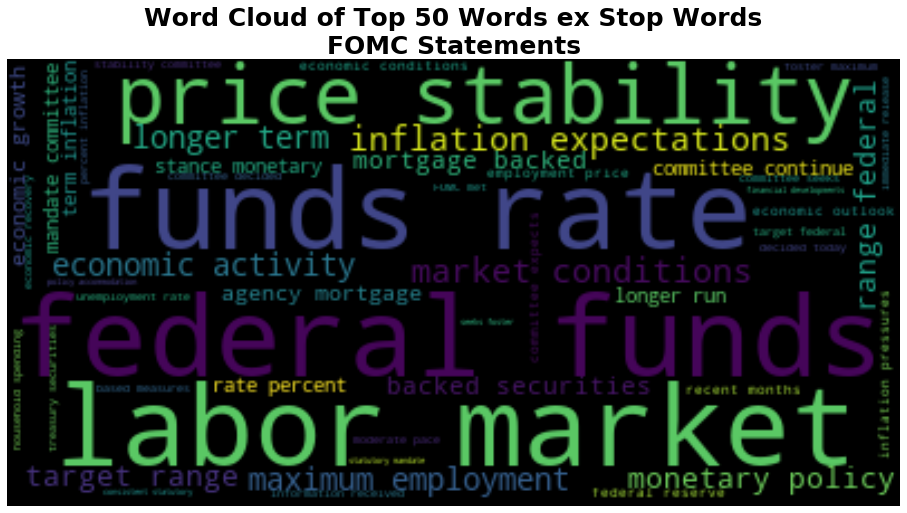

In [67]:
statements = df_FOMC[df_FOMC['document_type'] == 'statement']

plt.figure(figsize=(16, 10))

statement_text = ' '.join(statements['document_data_wo_stopwords'])
statement_wordcloud = WordCloud(max_words=50).generate(statement_text)
plt.imshow(statement_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Top 50 Words ex Stop Words\nFOMC Statements", fontweight='bold', fontsize = 25)
plt.show()

# Save the image in the img folder:
# Uncomment this to save file locally when it runs
#wordcloud.to_file("images/FOMC_statements_wordcloud.png")

### FOMC Minutes Word Cloud

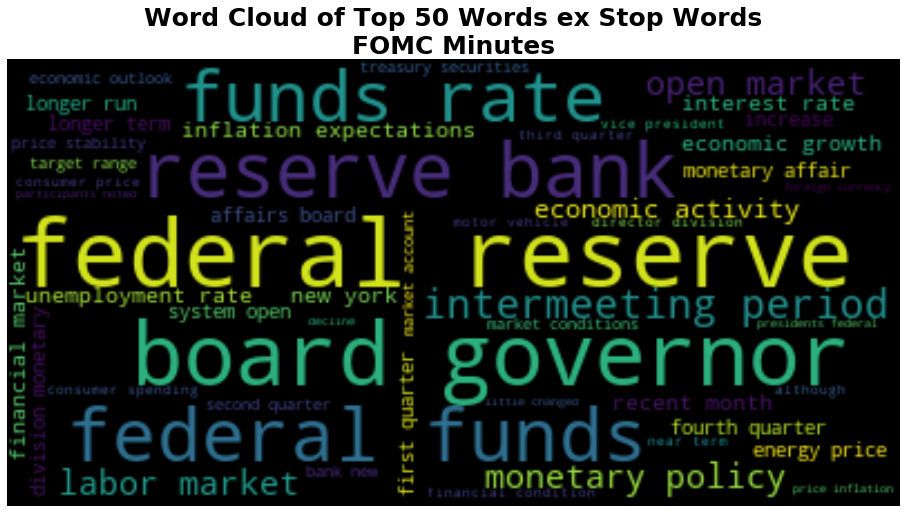

In [68]:
minutes = df_FOMC[df_FOMC['document_type'] == 'minutes']

plt.figure(figsize=(16, 10))

minute_text = ' '.join(minutes['document_data_wo_stopwords'])
minute_wordcloud = WordCloud(max_words=50).generate(minute_text)
# minute_wordcloud = WordCloud(max_words=50, background_color='white').generate(minute_text)
plt.imshow(minute_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Top 50 Words ex Stop Words\nFOMC Minutes", fontweight='bold', fontsize = 25)
plt.show()

# Save the image in the img folder:
# Uncomment this to save file locally when it runs
#wordcloud.to_file("images/FOMC_minutes_wordcloud.png"

# Document Sentiment Analysis

#### Load Loughran-McDonald Postive & Negative Word Lists
source: https://sraf.nd.edu/textual-analysis/resources/#LM%20Sentiment%20Word%20Lists

In [159]:
df_FOMC_sentiment = df_FOMC
df_FOMC_sentiment.describe()

,press_conference,label_market,label_FED
count,400.000000,400.000000,400.000000
mean,0.227500,0.737500,1.105000
std,0.419743,0.542521,0.848986
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,1.000000,1.000000
75%,0.000000,1.000000,2.000000
max,1.000000,2.000000,2.000000


In [160]:
def createLoughranMcDonaldWordList(file_name):
    file = open('data/LoughranMcDonald/'+file_name, "r")
    words = file.readlines()
    words = [word.strip().lower() for word in words]
    return words

LM_negative_words = createLoughranMcDonaldWordList('LoughranMcDonald_NegativeWordList.csv')
LM_postive_words = createLoughranMcDonaldWordList('LoughranMcDonald_PositiveWordList.csv')

#### Count Positive and Negative Words in Each Document to Calculate Sentiment Score

In [161]:
def calcSentiment(document_data):
    words = document_data.split(' ')
    positive_words = [word for word in words if word in LM_postive_words]
    negative_words = [word for word in words if word in LM_negative_words]
    positive_count = len(positive_words)
    negative_count = len(negative_words)
    LM_sentiment_score = (positive_count) - negative_count
    return [LM_sentiment_score, positive_count, negative_count, positive_words, negative_words]

# df_FOMC_sentiment['num_LM_positive_words'] = df_FOMC_sentiment['document_data'].apply(lambda data: calcSentiment(data)[1])
# df_FOMC_sentiment['num_LM_negative_words'] = df_FOMC_sentiment['document_data'].apply(lambda data: calcSentiment(data)[2])
df_FOMC_sentiment['LM_sentiment_score'] = df_FOMC_sentiment['document_data'].apply(lambda data: calcSentiment(data)[0])
df_FOMC_sentiment['LM_positive_words'] = df_FOMC_sentiment['document_data'].apply(lambda data: calcSentiment(data)[3])
df_FOMC_sentiment['LM_netagive_words'] = df_FOMC_sentiment['document_data'].apply(lambda data: calcSentiment(data)[4])

df_FOMC_sentiment['LM_sentiment_score_512'] = df_FOMC_sentiment['document_data_512'].apply(lambda data: calcSentiment(data)[0])
# df_FOMC_sentiment['LM_positive_words_512'] = df_FOMC_sentiment['document_data_512'].apply(lambda data: calcSentiment(data)[3])
# df_FOMC_sentiment['LM_netagive_words_512'] = df_FOMC_sentiment['document_data_512'].apply(lambda data: calcSentiment(data)[4])

In [162]:
df_FOMC_sentiment.head()

,FOMC_date,document_type,document_data,document_data_wo_stopwords,document_data_512,document_data_wo_stopwords_512,press_conference,release_date,label_market,label_FED,str_label_market,str_label_FED,LM_sentiment_score,LM_positive_words,LM_netagive_words,LM_sentiment_score_512
0,2006-01-31,minutes,minutes of the FOMC january 31 2006 a meeting ...,minutes FOMC january 31 2006 meeting FOMC held...,mr reinhart secretary and economist ms danker ...,conduct,0,2006-02-21,1,1,neutral,neutral,-2,[],"[discontinuance, cease]",-2
1,2006-01-31,statement,for immediate release share the FOMC decided t...,immediate release share FOMC decided today rai...,for immediate release share the FOMC decided t...,immediate release share FOMC decided today rai...,0,2006-01-31,1,1,neutral,neutral,2,"[attainment, stability]",[],2
2,2000-10-03,statement,for immediate release the FOMC at its meeting ...,immediate release FOMC meeting today decided m...,percent recent data have indicated that the ex...,immediate release FOMC meeting today decided m...,0,2000-10-03,0,2,negative,positive,2,"[enhanced, advances, conducive, stability]","[poses, against]",2
3,2000-10-03,minutes,minutes of the FOMC october 3 2000 a meeting o...,minutes FOMC october 3 2000 meeting FOMC held ...,aggregate demand and aggregate supply were com...,advance twelve months ended august slightly la...,0,2000-11-16,0,2,negative,positive,-26,"[boosted, gains, strong, gains, strengthening,...","[slowed, dropped, declines, slowdown, unemploy...",-11
4,2000-03-21,statement,for immediate release the FOMC voted today to ...,immediate release FOMC voted today raise targe...,the FOMC met in february the FOMC remains conc...,immediate release FOMC voted today raise targe...,0,2000-03-21,0,2,negative,positive,-3,[stability],"[concerned, imbalances, undermine, against]",-3


#### Add Label Each Document Based on Sentiment Score

In [163]:
def calcLMSentimentLabel(LM_sentiment_score):
    LM_sentiment_label = 'neutral'
    
    if LM_sentiment_score < -1:
        LM_sentiment_label = 'negative'
    elif LM_sentiment_score > 1:
        LM_sentiment_label = 'positive'
        
    return LM_sentiment_label
    
df_FOMC_sentiment['LM_sentiment_label_str'] = df_FOMC_sentiment['LM_sentiment_score'].apply(lambda score: calcLMSentimentLabel(score))
df_FOMC_sentiment['LM_sentiment_label_str_512'] = df_FOMC_sentiment['LM_sentiment_score_512'].apply(lambda score: calcLMSentimentLabel(score))

In [164]:
df_FOMC_sentiment.sort_values(['FOMC_date', 'document_type']).head()

,FOMC_date,document_type,document_data,document_data_wo_stopwords,document_data_512,document_data_wo_stopwords_512,press_conference,release_date,label_market,label_FED,str_label_market,str_label_FED,LM_sentiment_score,LM_positive_words,LM_netagive_words,LM_sentiment_score_512,LM_sentiment_label_str,LM_sentiment_label_str_512
382,1993-02-03,minutes,minutes of the FOMC meeting of february 2 3 19...,minutes FOMC meeting february 2 3 1993 meeting...,the rate was somewhat volatile in late decembe...,measure prices increased considerably smaller ...,0,1993-03-26,1,0,neutral,negative,-62,"[pleasure, satisfactory, satisfactory, opportu...","[discontinuance, cease, questions, question, u...",-18,negative,negative
178,1993-03-23,minutes,minutes of the FOMC meeting of march 23 1993 a...,minutes FOMC meeting march 23 1993 meeting FOM...,least a degree of unease with regard to underl...,weakness economies major industrialized countr...,0,1993-05-21,1,0,neutral,negative,-43,"[strong, gains, strengthened, advances, advanc...","[unemployment, sharply, depressed, claims, une...",-1,negative,neutral
159,1993-05-18,minutes,minutes of the FOMC meeting of may 18 1993 a m...,minutes FOMC meeting may 18 1993 meeting FOMC ...,while recent indicators of economic activity w...,instruments bond stock mutual funds experience...,0,1993-07-09,1,0,neutral,negative,-57,"[strong, gains, despite, strong, gains, gains,...","[slowed, sluggish, diminished, disappointing, ...",-8,negative,negative
396,1993-07-07,minutes,minutes of the FOMC meeting of july 6 7 1993 a...,minutes FOMC meeting july 6 7 1993 meeting FOM...,not ebullient were viewed as more promising pa...,anecdotal reports still suggested generally ca...,0,1993-08-20,1,0,neutral,negative,-34,"[strength, gains, gains, rebound, highest, imp...","[absence, slow, slowed, declined, unemployment...",-2,negative,negative
378,1993-08-17,minutes,minutes of the FOMC meeting of august 17 1993 ...,minutes FOMC meeting august 17 1993 meeting FO...,labor and product markets coupled with some te...,m2 estimated grown rate close lower end commit...,0,1993-09-24,1,0,neutral,negative,-35,"[gain, strong, gain, rebounded, gain, strong, ...","[decline, lost, slower, unemployment, dropped,...",-7,negative,negative


#### Split df_FOMC_sentiment Into Two Dataframes : Minute and Statement

In [165]:
df_FOMC_statement_sentiment = df_FOMC_sentiment[df_FOMC_sentiment['document_type'] == 'statement']
df_FOMC_minute_sentiment = df_FOMC_sentiment[df_FOMC_sentiment['document_type'] == 'minutes']


### Counts of LM Sentiment Labels - Total Document

Total LM Sentiment Label Counts
negative    240
positive     94
neutral      66
Name: LM_sentiment_label_str, dtype: int64
-----------------------------------------------------


Text(0.5, 1.0, 'LM Sentiment Label Counts')

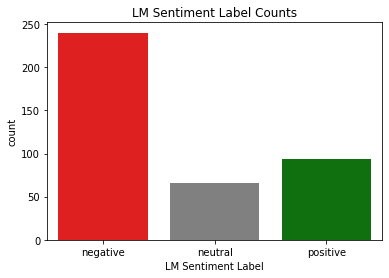

In [166]:
print("Total LM Sentiment Label Counts")
print(df_FOMC_sentiment['LM_sentiment_label_str'].value_counts())
print('-----------------------------------------------------')

ax = sns.countplot(df_FOMC_sentiment['LM_sentiment_label_str'], order=['negative', 'neutral', 'positive'], palette=['red','grey','green'])
plt.xlabel('LM Sentiment Label')
plt.title('LM Sentiment Label Counts')


LM Sentiment Label Counts by Document Type
document_type  LM_sentiment_label_str
minutes        negative                  199
               neutral                    10
               positive                    8
statement      positive                   86
               neutral                    56
               negative                   41
Name: LM_sentiment_label_str, dtype: int64

-----------------------------------------------------



Text(0.5, 1, 'LM Sentiment Label Counts by Document Type')

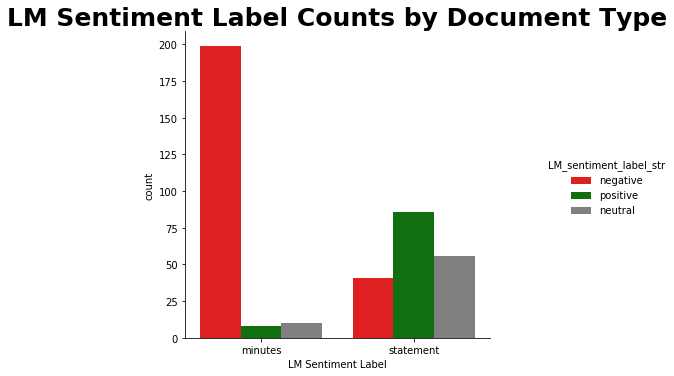

In [167]:
print("LM Sentiment Label Counts by Document Type")
print(df_FOMC_sentiment.groupby('document_type')['LM_sentiment_label_str'].value_counts())
print('\n-----------------------------------------------------\n')

# ax = sns.countplot(df_FOMC_minute_sentiment['LM_sentiment_label_str'], order=['negative', 'neutral', 'positive'], palette=['red','grey','green'])
# plt.xlabel('LM Sentiment Label')
# plt.title('FOMC Minute Document LM Sentiment Label Counts')

ax = sns.catplot(data=df_FOMC_sentiment, x='document_type', hue='LM_sentiment_label_str', kind='count', palette=['red','green','gray'])
plt.xlabel('LM Sentiment Label')
plt.title('LM Sentiment Label Counts by Document Type', fontweight='bold', fontsize = 25)

LM Sentiment Label Counts for Middle 512 Words by Document Type
document_type  LM_sentiment_label_str_512
minutes        negative                      147
               neutral                        35
               positive                       35
statement      neutral                        91
               positive                       71
               negative                       21
Name: LM_sentiment_label_str_512, dtype: int64

-----------------------------------------------------



Text(0.5, 1, 'LM Sentiment Label Counts for Middle 512 Words\nby Document Type')

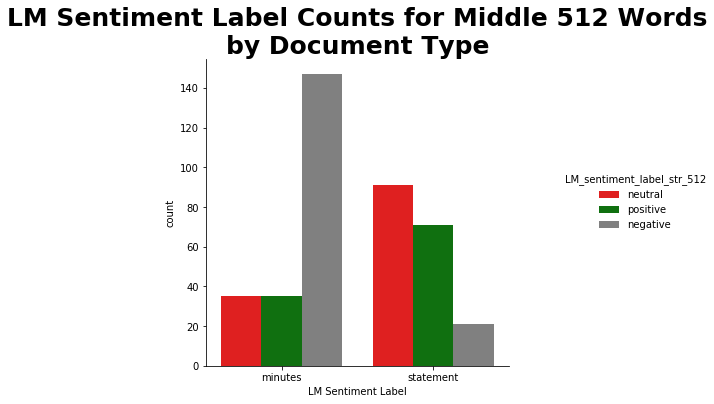

In [79]:
print("LM Sentiment Label Counts for Middle 512 Words by Document Type")
print(df_FOMC_sentiment.groupby('document_type')['LM_sentiment_label_str_512'].value_counts())
print('\n-----------------------------------------------------\n')

# ax = sns.countplot(df_FOMC_minute_sentiment['LM_sentiment_label_str'], order=['negative', 'neutral', 'positive'], palette=['red','grey','green'])
# plt.xlabel('LM Sentiment Label')
# plt.title('FOMC Minute Document LM Sentiment Label Counts')

ax = sns.catplot(data=df_FOMC_sentiment, x='document_type', hue='LM_sentiment_label_str_512', kind='count', palette=['red','green','gray'])
plt.xlabel('LM Sentiment Label')
plt.title('LM Sentiment Label Counts for Middle 512 Words\nby Document Type', fontweight='bold', fontsize = 25)

### Change in LM Sentiment by Document Type

#### Full Document LM Sentiment Value

Text(0.5, 1.0, 'Change in LM Sentiment by Document Type\n1992-2020')

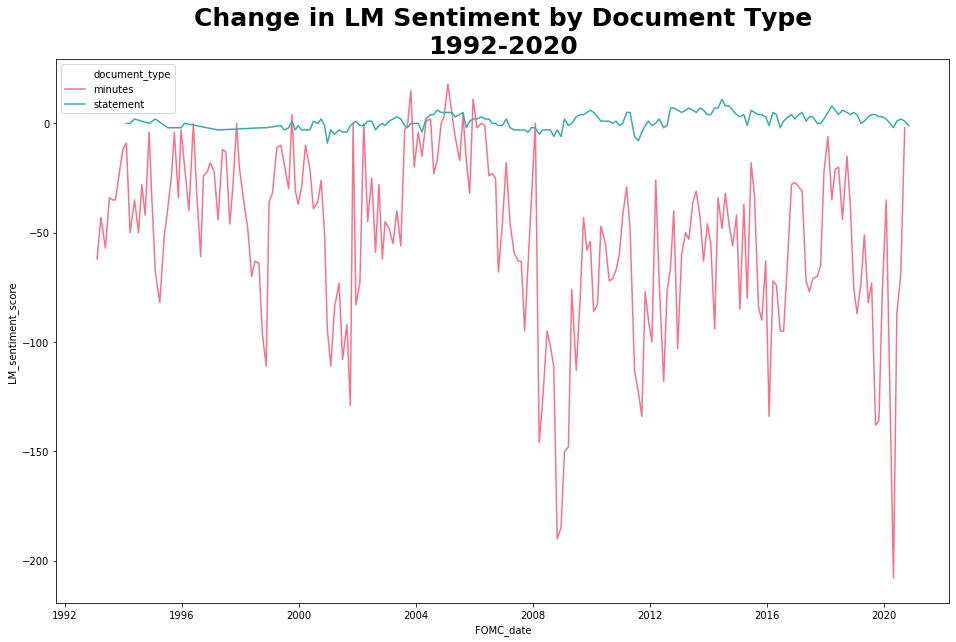

In [80]:
colors = sns.color_palette('husl', n_colors =2)
color_map = dict(zip(['minutes','statement'], colors))

plt.figure(figsize=(16, 10))
sns.lineplot(x=df_FOMC_sentiment['FOMC_date'], y=df_FOMC_sentiment['LM_sentiment_score'], hue=df_FOMC['document_type'], palette=color_map)
plt.title("Change in LM Sentiment by Document Type\n1992-2020", fontweight='bold', fontsize = 25)


#### Middle 512 Words LM Sentiment Value

Text(0.5, 1.0, 'Change in LM Sentiment of Middle 512 Words\nby Document Type\n1992-2020')

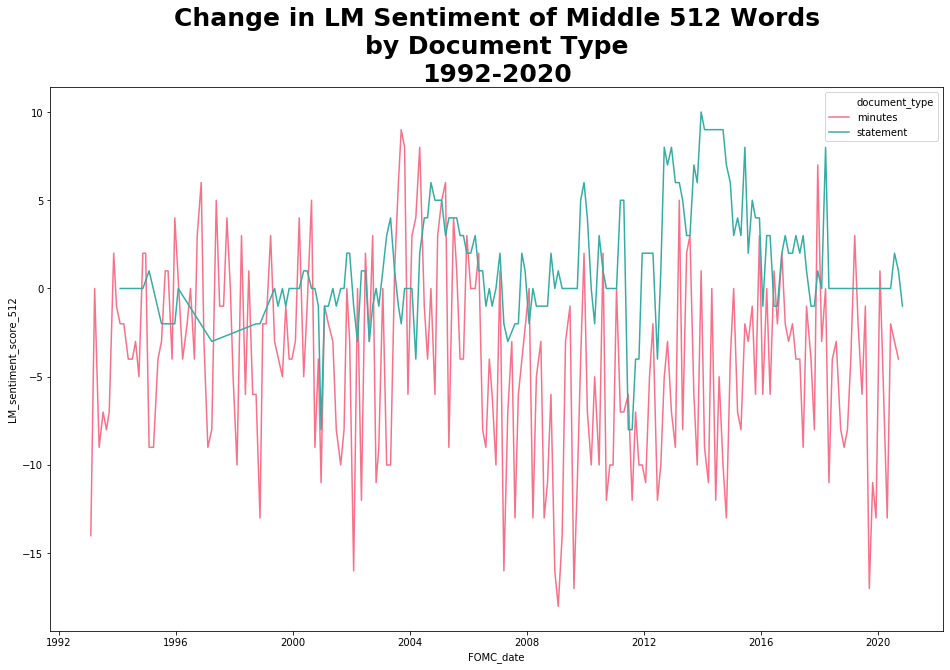

In [81]:
colors = sns.color_palette('husl', n_colors =2)
color_map = dict(zip(['minutes','statement'], colors))

plt.figure(figsize=(16, 10))
sns.lineplot(x=df_FOMC_sentiment['FOMC_date'], y=df_FOMC_sentiment['LM_sentiment_score_512'], hue=df_FOMC['document_type'], palette=color_map)
plt.title("Change in LM Sentiment of Middle 512 Words\nby Document Type\n1992-2020", fontweight='bold', fontsize = 25)

## FOMC Statements Word Cloud (Positive + Negative Words Only)

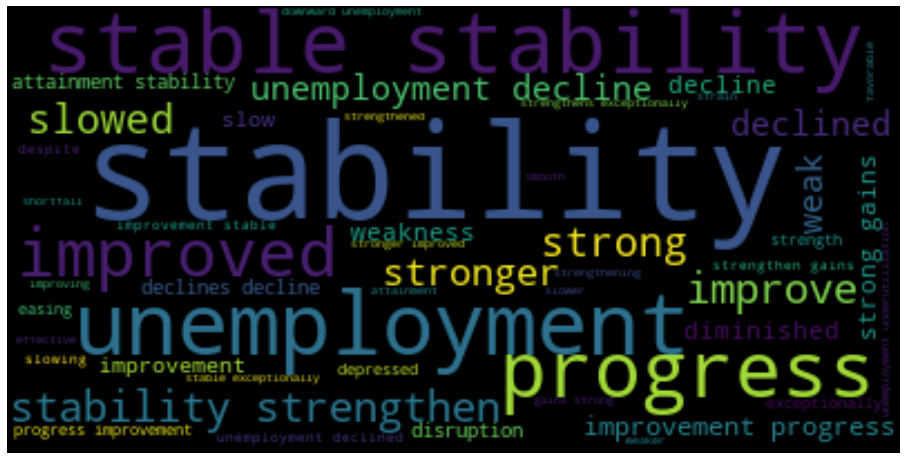

In [100]:
plt.figure(figsize=(16, 10))

positive_words = ' '.join(df_FOMC_statement_sentiment['LM_positive_words'].apply(lambda words: ' '.join(words)))
negative_words = ' '.join(df_FOMC_statement_sentiment['LM_netagive_words'].apply(lambda words: ' '.join(words)))
words = positive_words + negative_words
words_wordcloud = WordCloud(max_words=50).generate(words)
# minute_wordcloud = WordCloud(max_words=50, background_color='white').generate(minute_text)
plt.imshow(words_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Save the image in the img folder:
# Uncomment this to save file locally when it runs
#wordcloud.to_file("images/FOMC_minutes_wordcloud.png"

## FOMC Minutes Word Cloud (Positive + Negative Words Only)

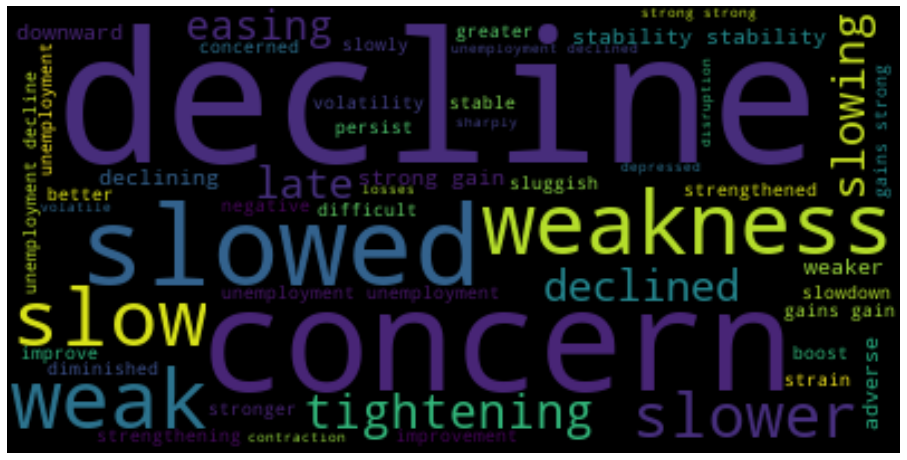

In [83]:
plt.figure(figsize=(16, 10))

positive_words = ' '.join(df_FOMC_minute_sentiment['LM_positive_words'].apply(lambda words: ' '.join(words)))
negative_words = ' '.join(df_FOMC_minute_sentiment['LM_netagive_words'].apply(lambda words: ' '.join(words)))
words = positive_words + negative_words
words_wordcloud = WordCloud(max_words=50).generate(words)
# minute_wordcloud = WordCloud(max_words=50, background_color='white').generate(minute_text)
plt.imshow(words_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Save the image in the img folder:
# Uncomment this to save file locally when it runs
#wordcloud.to_file("images/FOMC_minutes_wordcloud.png"

### Confusion Matrixes

#### All Documents LM Sentiment Value vs Market Label

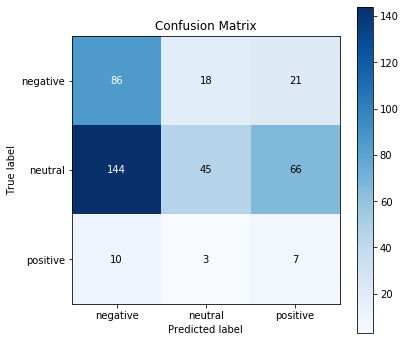

In [84]:
# !pip install scikit-plot
import scikitplot as skplt

true_label = df_FOMC_sentiment['str_label_market']
predicted_label = df_FOMC_sentiment['LM_sentiment_label_str']
skplt.metrics.plot_confusion_matrix(true_label, predicted_label, figsize=(6,6))

#### FOMC Minute Documents LM Sentiment Value vs Market Label

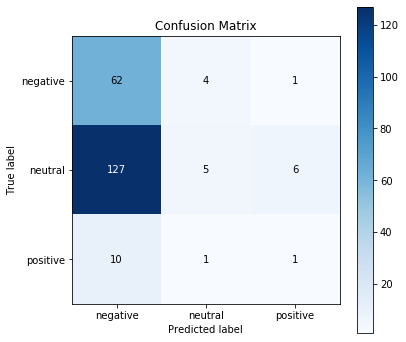

In [85]:
true_label = df_FOMC_minute_sentiment['str_label_market']
predicted_label = df_FOMC_minute_sentiment['LM_sentiment_label_str']
skplt.metrics.plot_confusion_matrix(true_label, predicted_label, figsize=(6,6))

#### Middle 512 Words All Documents Confusion Matrix: LM Sentiment Value vs Market Label

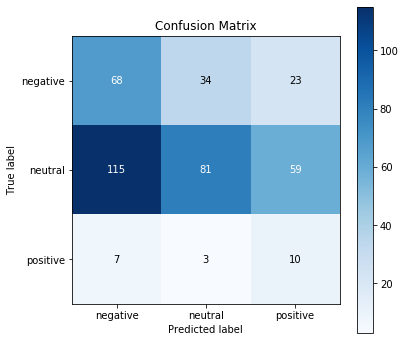

In [178]:
true_label = df_FOMC_sentiment['str_label_market']
predicted_label = df_FOMC_sentiment['LM_sentiment_label_str_512']
skplt.metrics.plot_confusion_matrix(true_label, predicted_label, figsize=(6,6))

# ERIN USE ME - Confusion Matrix L-M Lexicon vs Market Label

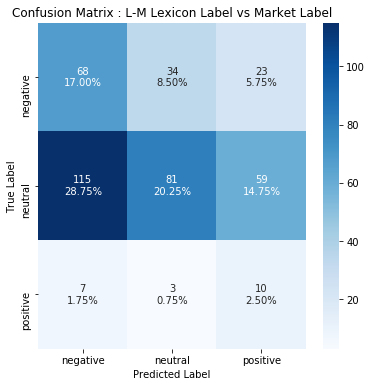

(400, 18)

In [184]:
def words_to_num_label(data):
    if data == 'negative':
        return 0
    elif data == 'neutral':
        return 1
    elif data == 'positive':
        return 2

true = df_FOMC_sentiment['label_market']
predicted = df_FOMC_sentiment['LM_sentiment_label_str_512'].apply(lambda data: words_to_num_label(data))

cm = skplt.metrics.confusion_matrix(true , predicted)

group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(3,3)
label_names = ['negative', 'neutral', 'positive']


fig,ax = plt.subplots(figsize=(6,6))
heatmap =sns.heatmap(cm, annot=labels, fmt="", cmap='Blues',ax=ax,xticklabels=label_names,yticklabels=label_names)
plt.title('Confusion Matrix : L-M Lexicon Label vs Market Label')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [185]:
from sklearn.metrics import accuracy_score, f1_score,confusion_matrix, classification_report

classification_rep = classification_report(true,predicted,target_names=['negative', 'neutral', 'positive'])
print(classification_rep)

              precision    recall  f1-score   support

    negative       0.36      0.54      0.43       125
     neutral       0.69      0.32      0.43       255
    positive       0.11      0.50      0.18        20

    accuracy                           0.40       400
   macro avg       0.38      0.45      0.35       400
weighted avg       0.55      0.40      0.42       400



#### Middle 512 Words FOMC Minute Documents LM Sentiment Value vs Market Label

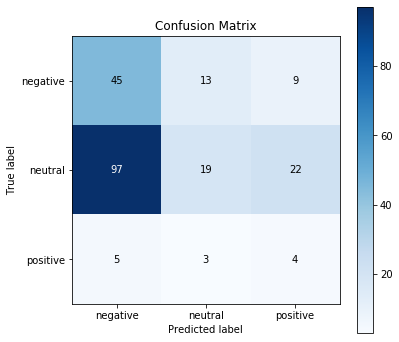

In [87]:
true_label = df_FOMC_minute_sentiment['str_label_market']
predicted_label = df_FOMC_minute_sentiment['LM_sentiment_label_str_512']
skplt.metrics.plot_confusion_matrix(true_label, predicted_label, figsize=(6,6))

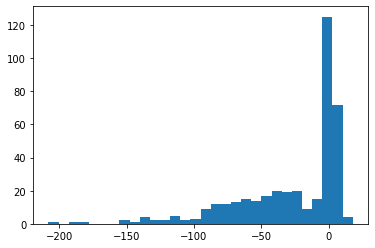

In [88]:
plt.hist(df_FOMC_sentiment['LM_sentiment_score'],  30)
plt.show()


### Correlation Analysis between Market Label and LM Sentiment Label

### All Documents Correlation

In [89]:
data_label = df_FOMC_sentiment['str_label_market'].astype('category').cat.codes
LM_sentiment_label = df_FOMC_sentiment['LM_sentiment_label_str'].astype('category').cat.codes

correlation = data_label.corr(LM_sentiment_label) 

print("All FOMC Documents")
print('Correlation Between Market Label and LM Sentiment Label')
print(correlation)

All FOMC Documents
Correlation Between Market Label and LM Sentiment Label
0.13039401164750367


### FOMC Minutes Correlation

In [90]:
data_label = df_FOMC_minute_sentiment['str_label_market'].astype('category').cat.codes
LM_sentiment_label = df_FOMC_minute_sentiment['LM_sentiment_label_str'].astype('category').cat.codes

correlation = data_label.corr(LM_sentiment_label) 

print("FOMC Minutes Only")
print('Correlation Between Market Label and LM Sentiment Label')
print(correlation)

FOMC Minutes Only
Correlation Between Market Label and LM Sentiment Label
0.07137253272001588


### Middle 512 Words All Documents Correlation

In [91]:
data_label = df_FOMC_sentiment['str_label_market'].astype('category').cat.codes
LM_sentiment_label = df_FOMC_sentiment['LM_sentiment_label_str_512'].astype('category').cat.codes

correlation = data_label.corr(LM_sentiment_label) 

print("Middle 512 Words All FOMC Documents")
print('Correlation Between Market Label and LM Sentiment Label')
print(correlation)

Middle 512 Words All FOMC Documents
Correlation Between Market Label and LM Sentiment Label
0.055190419973134695


### Middle 512 Words FOMC Minutes Correlation

In [92]:
data_label = df_FOMC_minute_sentiment['str_label_market'].astype('category').cat.codes
LM_sentiment_label = df_FOMC_minute_sentiment['LM_sentiment_label_str_512'].astype('category').cat.codes

correlation = data_label.corr(LM_sentiment_label) 

print("Middle 512 Words - FOMC Minute Documents Only")
print('Correlation Between Market Label and LM Sentiment Label')
print(correlation)

Middle 512 Words - FOMC Minute Documents Only
Correlation Between Market Label and LM Sentiment Label
0.073567488075087


# Create CSV of df_FOMC_sentiment for Colab

In [97]:
smaller_df = df_FOMC_sentiment[['FOMC_date', 'document_type', 'document_data_512','document_data_wo_stopwords_512', 'press_conference', 'release_date', 'label_market', 'label_FED','LM_sentiment_label_str','LM_sentiment_label_str_512']]

def convert_label_str_to_num(label_str):
    label_int = 0
    if label_str == 'neutral':
        label_int = 1
    elif label_str == 'positive':
        label_int = 2
    return label_int

smaller_df["label_LM"] = smaller_df['LM_sentiment_label_str'].apply(lambda score: convert_label_str_to_num(score))
smaller_df["label_LM_512"] = smaller_df['LM_sentiment_label_str_512'].apply(lambda score: convert_label_str_to_num(score))

smaller_df = smaller_df.drop(columns=['LM_sentiment_label_str', 'LM_sentiment_label_str_512'])

smaller_df.head()

/Users/Lex/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/Lex/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


,FOMC_date,document_type,document_data_512,document_data_wo_stopwords_512,press_conference,release_date,label_market,label_FED,label_LM,label_LM_512
0,2006-01-31,minutes,account messrs oliner and slifman associate di...,messrs moskow poole hoenig alternate members F...,0,2006-02-21,1,1,0,1
1,2006-01-31,statement,for immediate release share the FOMC decided t...,immediate release share FOMC decided today rai...,0,2006-01-31,1,1,2,2
2,2000-10-03,statement,utilization of the pool of available workers r...,immediate release FOMC meeting today decided m...,0,2000-10-03,0,2,2,1
3,2000-10-03,minutes,indexes of stock market prices declined somewh...,though previous policy tightening actions yet ...,0,2000-11-16,0,2,0,0
4,2000-03-21,statement,growth and of the information currently availa...,raise target federal funds rate 25 basis point...,0,2000-03-21,0,2,0,1


In [99]:
smaller_df.to_csv("data_for_colab.csv", index=False)